In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from itertools import product

In [4]:
from commons import smoothen

In [5]:
fontsize = 14

# Loading the data

## Raw data

Our Scan-O-matic data comes in the form of a NumPy array named `curves_raw.npy`, which we load here. Additionally, we smoothen it with an window of 5 :

In [6]:
Nt = smoothen(np.load("curves_raw.npy"), 5)

For convenience, we also get the dimensions of this array :

In [7]:
n_plates, n_rows, n_columns, n_points = Nt.shape
plates, rows, columns, points = map(np.arange, Nt.shape)

## Distances

We will colour the curves according to the distance of a population to its closest border of the populations grid, or respectively its inverse :

In [8]:
dists = np.array([
    [
    #   str ensures categorical interpretation
        str(1 + min(r, c, n_rows-1 - r, n_columns-1 - c))
        for c in columns
    ]
    for r in rows
])

## Dataframe

Let's make a `pd.DataFrame` containing the data we will display :

In [9]:
data = pd.DataFrame(
    index = pd.MultiIndex.from_product(
        (plates, rows, columns, points),
        names = ("plate", "row", "column", "time")
    )
).reset_index()

In [10]:
data["N"] = Nt.reshape(-1)

`sns.lineplot` needs a **unit** column to display curves individually :

In [11]:
data["units"] = data["plate"].astype(str) + " " + data["row"].astype(str) + " " + data["column"].astype(str)

Incorporating the distances to the closest border requires repeating the 1536 (32 x 48) entries for the 4 plates and all time points :

In [12]:
data["position"] = np.tile(np.repeat(dists.reshape(-1), n_points), n_plates)

# Figure

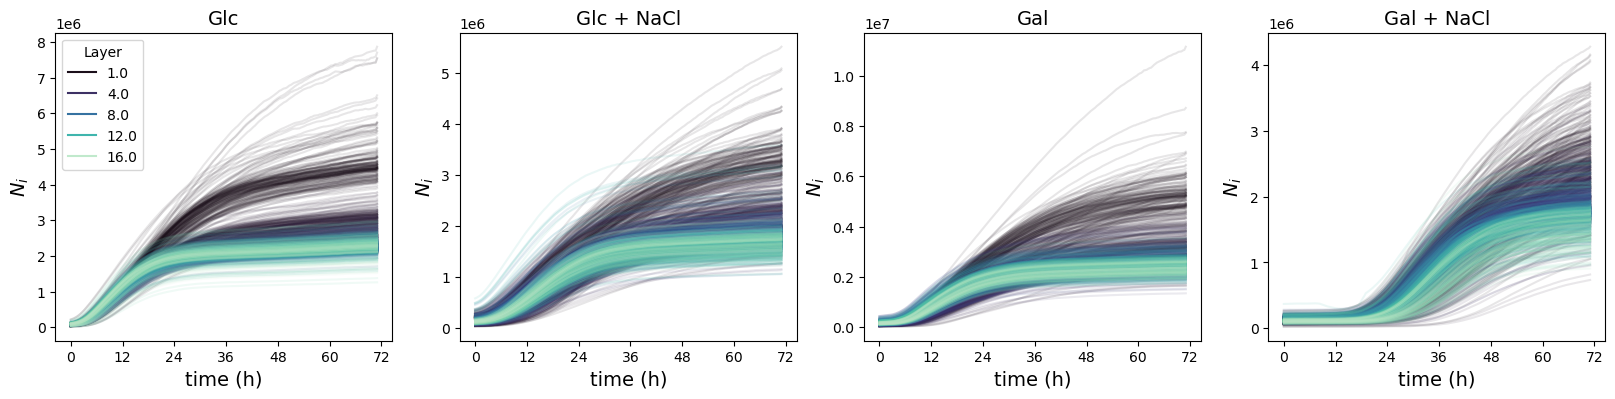

In [13]:
fig, axes = plt.subplots(ncols = 4, figsize = (20, 4))

indexes = (1, 2, 3, 0)
names = ("Glc", "Glc + NaCl", "Gal", "Gal + NaCl")
palette = sns.color_palette("mako", 16)

for p, env, ax in zip(indexes, names, axes):
    sns.lineplot(
        data[data["plate"] == p],
        x         = "time",
        y         = "N",
        hue       = "position",
        units     = "units",
        estimator = None,
        ax        = ax,
        legend    = bool(p == indexes[0]),
        alpha     = 0.1,
        palette   = palette
    )
    
    ax.set_title(env, fontsize = fontsize)
    ax.set_xlabel("time (h)", fontsize = fontsize)
    ax.set_ylabel(r"$N_i$", fontsize = fontsize)
    ax.set_xticks([0, 36, 72, 108, 144, 180, 216], labels = [0, 12, 24, 36, 48, 60, 72])

l = axes[0].legend(alignment = "left", title_fontsize = fontsize, fontsize = fontsize)
legend = axes[0].legend([ l.legendHandles[i-1] for i in [1, 4, 8, 12, 16] ], ["1.0", "4.0", "8.0", "12.0", "16.0"])
legend.set_title("Layer")
# somehow transparency got applied to the legend as well, in my version of seaborn -> revert
for handle in legend.legendHandles:
    handle.set_alpha(1)

fig.savefig("plots/figure-1/time-series_positional.pdf", bbox_inches = "tight")
fig.savefig("plots/figure-1/time-series_positional.png", bbox_inches = "tight");